#  Least-squares parameter estimation of AR models

The model structure considered is the (Auto-Regressive) model
$$ A(\text{q})y(k) = e(k+n), $$
 where $e(k)$ is a zero-mean white noise sequence.
 
 The model can be written
 \begin{align*}
  (\text{q}^n + a_1\text{q}^{n-1} + \cdots + a_n)y(k) &= \text{q}^n e(k)\\
  y(k+n) + a_1 y(k+n-1) + \cdots + a_n y(k) &=  e(k+n)\\
  y(k+1) + a_1y(k) + \cdots + a_n y(k-n+1) &= e(k+1)
  \end{align*}
  The one-step-ahead predictor for this model becomes 
  \begin{align*}
  \hat{y}(k+1) &= -a_1 y(k) - a_2 y(k-1) - \cdots - a_n y(k-n+1) 
               & = \underbrace{\begin{bmatrix} -y(k) & \cdots & -y(k-n+1)\end{bmatrix}}_{\varphi^{T}(k+1)} \underbrace{\begin{bmatrix} a_1\\\vdots\\a_n\end{bmatrix}}_{\theta}\\
   &= \varphi^{T}(k+1)\theta.
  \end{align*}
  Note that the white noise term $e(k+1)$ by definition cannot be predicted from knowledge of previous values in the sequence (which we don't know) nor from previous output values $y(t), \; t \le k$ (which could have been used to estimate $\hat{e}(k)$). Therefore $e(k+1)$ is predicted by its mean value which is zero. Note also that if our model with $\theta = \theta^*$ is perfect ($\theta^*$ contains the true parameters for the system which generated the data), then the prediction error equals the white noise disturbance: $\epsilon(k+1) = y(k+1) - \varphi^{T}(k+1)\theta^* = e(k+1)$. Therefore, we can check how good a models is by testing how close the prediction errors resembles a white noise sequence.

  The system of equations in the unknown system parameters $\theta$ (the normal equations) is
  $ \Phi \theta = y, $
  where
  \begin{align*}
  \Phi &= \begin{bmatrix} \varphi^{T}(n+1)\\\varphi^{T}(n+2)\\\vdots\\\varphi^{T}(N)\end{bmatrix},\\
  y &= \begin{bmatrix} y(n+1)\\y(n+2)\\\vdots\\y(N)\end{bmatrix}.
  \end{align*}

  The least-squares solution to this system of equations is, by definition, the solution $\hat{\theta}$ which minimizes the sum of squares of the residuals $\epsilon = y-\Phi\theta$, i.e. the solution that minimizes the criterion
  $ J(\theta) = \epsilon^{T}\epsilon = \sum_i \epsilon_i^2. $ 
  It is given by 
  $ \hat{\theta}_{LS} = \underbrace{(\Phi^{T}\Phi)^{-1}\Phi^{T}}_{\Phi^+} y, $
  where $\Phi^+$ is called the *Moore-Penrose inverse* of the (typically) non-square, tall matrix $\Phi$. 



## Example
For a first-order model, 
$$ y(k+1) + ay(k) = e(k+1) $$ we have only one parameter $\theta = a$ to estimate. The one-step-ahead predictor is
$$\hat{y}_{k+1} = -a y_k = -y_k a = -\varphi_{k+1} \theta, \qquad \varphi_{k+1} = -y_k$$

The normal equations become
$$ \begin{bmatrix} \varphi_2^T\\\varphi_3^T\\\vdots\\\varphi_N^T\end{bmatrix}\theta = \begin{bmatrix}y_2\\y_3\\\vdots\\y_N\end{bmatrix} $$
$$ \begin{bmatrix} -y_1\\-y_2\\\vdots\\-y_{N-1}\end{bmatrix}a = \begin{bmatrix}y_2\\y_3\\\vdots\\y_N\end{bmatrix} $$

In [4]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import control.matlab as cm
%matplotlib notebook

### Simulate some data

<IPython.core.display.Javascript object>


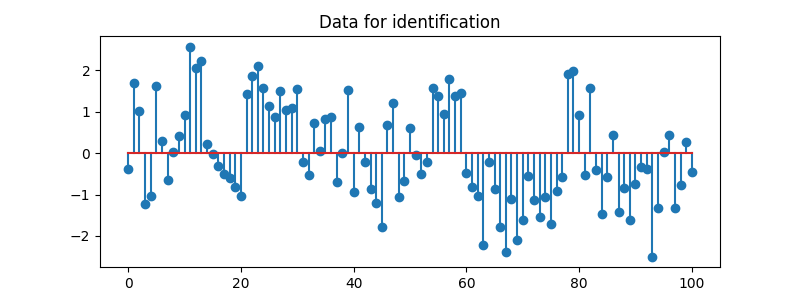

<IPython.core.display.Javascript object>


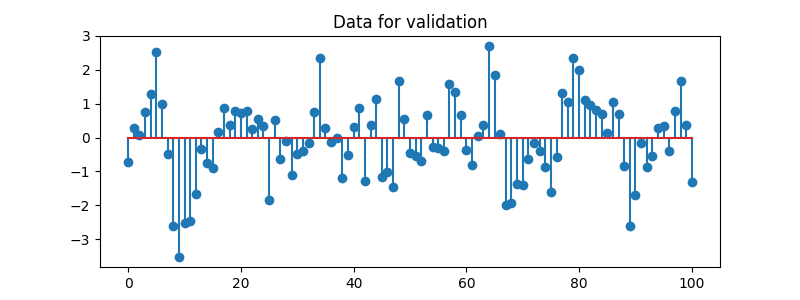

Text(0.5,1,'Data for validation')

In [15]:
a0 = -0.5; # TRUE VALUE
H = cm.tf([1,0],[1, a0], 1)
N = 100
e = np.random.randn(N+1) # Gaussian white noise 
e_v = np.random.randn(N+1) # Gaussian white noise for validation 
y, t, x = cm.lsim(H, e)
y_v, t_v, x_v = cm.lsim(H, e_v)
plt.figure(figsize = (8,3))
plt.stem(t, y);
plt.title('Data for identification')
plt.figure(figsize = (8,3))
plt.stem(t_v, y_v);
plt.title('Data for validation')

## Identify first order model

In [13]:
Phi = -y[1:-1]
Phi.shape = (N-1,1)
yy = y[2:]
theta_ls = np.linalg.lstsq(Phi, yy)
theta_ls

/home/kjartan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


(array([[-0.49410375]]), array([75.78438181]), 1, array([10.01875665]))

## Validation
The validation is always done one input-output data that were **not** used in the parameter estimation. It is also recommended to use a k-step-ahead predictor. See section about validation further down.

<IPython.core.display.Javascript object>


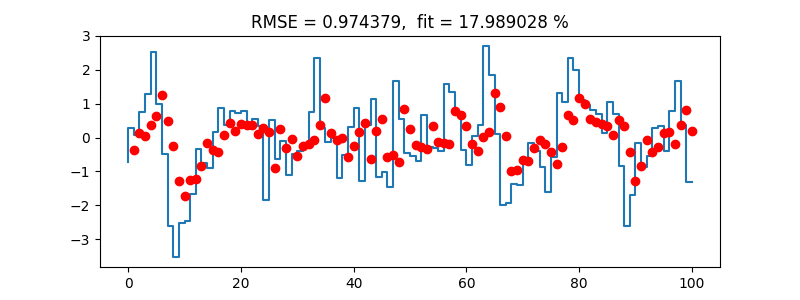

<IPython.core.display.Javascript object>


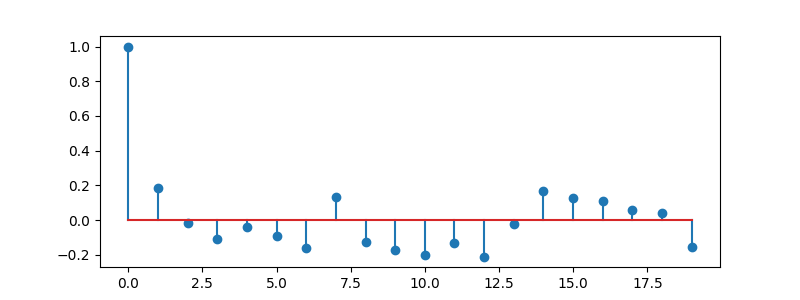

<StemContainer object of 3 artists>

In [30]:
ahat = theta_ls[0][0]
ypred = -ahat*y_v[:-1]
tpred = np.arange(1, N)
plt.figure(figsize=(8,3))
plt.step(range(N), y_v)
plt.plot(tpred, ypred, 'ro')

# Calculate the Root Mean Square Error (RMSE) and fit (in %)
err = y_v[tpred] - ypred
RMSE = np.sqrt(1.0/N * np.sum( np.square(y_v[tpred] - ypred)))
fit = 100 * (1 - np.linalg.norm(err)/np.linalg.norm(y_v - np.mean(y_v)))
plt.title("RMSE = %f,  fit = %f %%" % (RMSE, fit))

# Check whiteness of residual. The autocorrelation function should be close
# to a pulse 
def estimated_autocorrelation(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result
autocorr = estimated_autocorrelation(np.ravel(err))
plt.figure(figsize=(8,3))
plt.stem(autocorr[:20]);

In [27]:
err

array([[ 0.63501134],
       [-0.05033187],
       [ 0.71106353],
       [ 0.90613255],
       [ 1.88715064],
       [-0.25390764],
       [-0.97838905],
       [-2.3858004 ],
       [-2.2156758 ],
       [-0.79992978],
       [-1.21826032],
       [-0.45806008],
       [ 0.48675985],
       [-0.5848331 ],
       [-0.51353342],
       [ 0.5954117 ],
       [ 0.78079278],
       [-0.04376666],
       [ 0.60080755],
       [ 0.34016841],
       [ 0.40781541],
       [-0.14282013],
       [ 0.43967551],
       [ 0.06965948],
       [-2.00205892],
       [ 1.43269027],
       [-0.883417  ],
       [ 0.20337549],
       [-1.06627049],
       [ 0.06828031],
       [-0.14606861],
       [ 0.02681318],
       [ 0.84452512],
       [ 1.98012048],
       [-0.89830097],
       [-0.27390527],
       [ 0.05064293],
       [-1.18504896],
       [ 0.07314254],
       [ 0.57473932],
       [ 0.7245672 ],
       [-1.7146197 ],
       [ 1.00889424],
       [ 0.94933397],
       [-1.71742417],
       [-0